In [3]:
from prophet import Prophet
import pandas as pd
pd.set_option('precision', 3)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import os

In [4]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/prophet_TEST"
if not os.path.exists(output_path):
    if not os.path.exists("./output"):
        os.mkdir("./output")
    os.mkdir(output_path)

## Load Data From Files

In [5]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.407,...,2.841,14.296,9.429e+09,9.561e+09,6.812e+09,3.131e+08,6.227e+08,4.428e+08,606.622,608.082
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.405,...,-4.478,9.559,9.165e+09,9.107e+09,6.502e+09,3.834e+08,5.129e+08,3.661e+08,606.279,611.963
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.402,...,0.319,6.030,9.538e+09,9.025e+09,6.473e+09,6.433e+08,7.878e+08,5.644e+08,610.411,616.374
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.388,...,4.949,8.596,9.988e+09,9.341e+09,6.757e+09,5.161e+08,6.720e+08,4.863e+08,617.969,622.599
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.376,...,-2.012,4.617,9.644e+09,9.152e+09,6.618e+09,6.517e+08,6.139e+08,4.443e+08,624.767,627.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.222,...,0.381,25.366,5.134e+10,5.087e+10,4.114e+10,2.094e+09,2.165e+09,1.761e+09,4267.526,4315.057
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.252,...,-0.063,16.739,5.172e+10,5.162e+10,4.110e+10,8.183e+08,1.866e+09,1.484e+09,4295.341,4330.297
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.259,...,-2.861,11.774,5.166e+10,5.043e+10,3.993e+10,1.425e+09,2.484e+09,1.967e+09,4330.822,4351.796
2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,1.267,...,-3.461,8.557,5.080e+10,4.965e+10,3.920e+10,1.561e+09,2.277e+09,1.798e+09,4346.662,4367.402


## Fit Models Using All Data To Produce Final Forecast

In [6]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', food_category:'y'}, axis=1)
    return df

def fit_final_forecast_model(foodprice_df, food_category, all_dates):
    train_df = get_prophet_df(foodprice_df, food_category, all_dates)       # Select data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    future = model.make_future_dataframe(periods=18, freq='MS')             # Create the future period. 
    forecast = model.predict(future.iloc[-18:])                             # Produce the future period forecast. 
    historical_fit = model.predict(future.iloc[:-18])                       # Look at how well the model fits the data.
    return model, forecast, historical_fit

In [7]:
def plot_final_forecast(model, forecast, historical_fit):

    fig = model.plot(forecast, figsize=(10,4))
    ax = fig.axes[0]

    ax.plot(historical_fit.ds, historical_fit.yhat, alpha=0.5, color='purple', label='Historical Model Fit')
    ax.fill_between(historical_fit.ds, historical_fit.yhat_lower, historical_fit.yhat_upper, 
                    alpha=0.2, color='purple', label='Historical Model Fit Uncertainty')
    ax.set_title(f'CPI Forecast - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_final_{food_category}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_final_{food_category}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.48525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1611.11     0.0167109       2057.17           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1628.76   0.000326181       348.826       0.908       0.908      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1642.03    0.00919983        1031.4           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1647.52    0.00586892        190.46           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1656.5   0.000592439       284.102           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

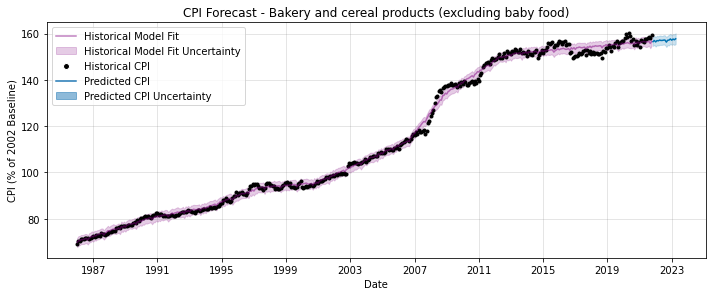

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.26367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1676.7     0.0100302       2574.52           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1691.15    0.00484144       884.957           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       1694.18   5.52858e-05       148.286   3.461e-07       0.001      370  LS failed, Hessian reset 
     299       1694.29   0.000624201       347.999           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       1694.91   3.21695e-05       121.761   8.372e-08       0.001      445  LS failed, Hessian reset 
     398       1695.97   4.50382e-05       214.208   9.158e-08       0.001      590  LS failed, Hessian rese

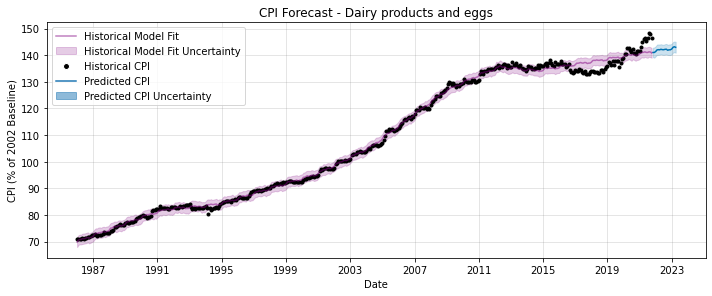

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.59942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1623.64    0.00905483       301.577      0.9436      0.9436      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1648.48    0.00192801       367.209           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1667.59   0.000542494       157.967           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1672.87   0.000689786        302.36      0.7389      0.7389      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1676.16   0.000118951       577.617      0.1747      0.1747      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

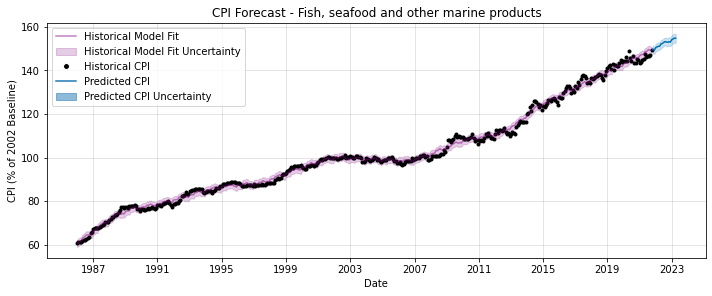

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38681
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2001.37    0.00796515        1552.3           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2067.01    0.00938988       3100.88           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2126.4    0.00301069       1213.13           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2166.35    0.00415757       2443.29           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2183.99    0.00814237       3449.64           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

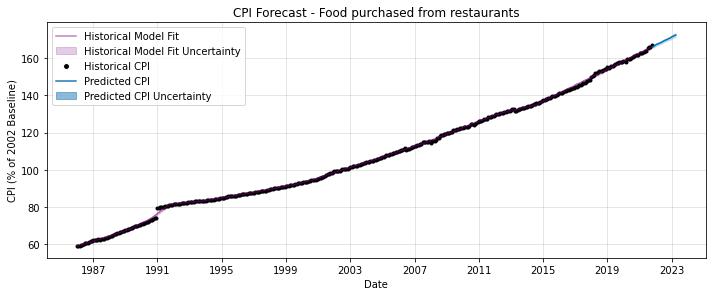

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1884.99   0.000563997       580.288           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1905.39    0.00326381       1377.97           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1910.06     0.0006319       365.228      0.6278      0.6278      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       1911.57   1.02355e-05       144.673   4.308e-08       0.001      490  LS failed, Hessian reset 
     399       1911.73   0.000278992       167.818           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1912.16   0.000207224    

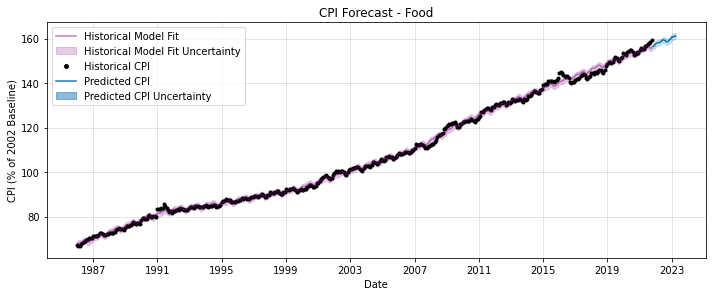

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.57264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1364.36     0.0173323       515.352           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       1369.15    7.9942e-05       100.235   8.315e-07       0.001      246  LS failed, Hessian reset 
     199       1369.61    0.00369588        131.46      0.1654           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1371.61   8.19661e-05        107.38           1           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1372.12   0.000170225         73.92      0.7074      0.7074      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1372.22   1.87434e-07    

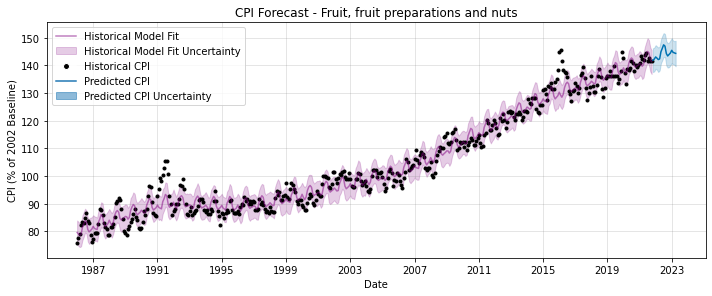

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.12951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1552.4    0.00782644       1175.57           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1569.8    0.00618345        425.48           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       1572.47   5.07592e-05         122.4   4.353e-07       0.001      340  LS failed, Hessian reset 
     272        1572.8   3.63702e-05       120.026    2.19e-07       0.001      398  LS failed, Hessian reset 
     299       1573.01   0.000193707        100.31           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388        1573.7   2.24185e-05       50.9807    1.47e-07       0.001      604  LS failed, Hessian rese

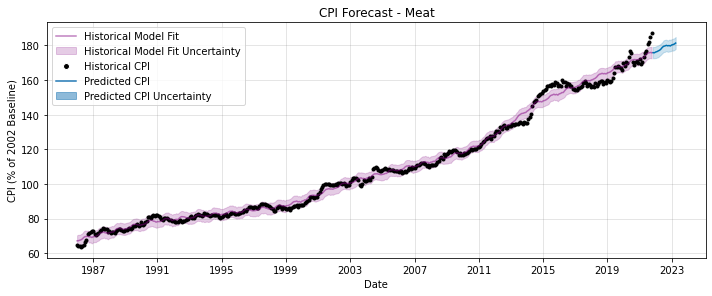

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.22577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1661.72    0.00341491       568.578           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1704.19   0.000452209       201.436           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1720.88   0.000149751       896.986      0.5556      0.5556      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1725.42    0.00331808       908.576           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       1731.14   6.25865e-05       311.876   2.973e-07       0.001      596  LS failed, Hessian reset 
     499       1732.36    0.00208784    

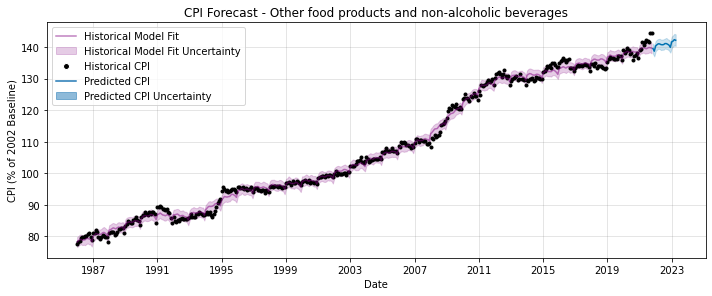

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.70353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1231.33     0.0023463       112.084           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       1233.04   0.000149016       90.6144   9.882e-07       0.001      255  LS failed, Hessian reset 
     199       1233.12   3.01537e-05       65.1196        0.81        0.81      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       1233.23   0.000229779       140.266   1.934e-06       0.001      347  LS failed, Hessian reset 
     263       1233.34   4.84072e-05       68.8423   7.197e-07       0.001      447  LS failed, Hessian reset 
     299       1233.35   1.38783e-07       49.4171      0.4945      0.4945      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

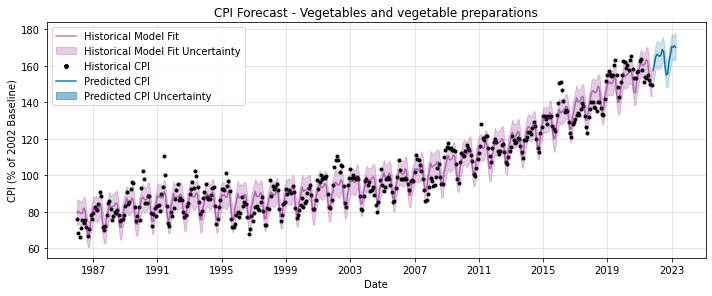

In [8]:
all_forecasts = {}

for food_category in foodprice_categories:

    model, forecast, historical_fit = fit_final_forecast_model(foodprice_df, food_category, all_dates=foodprice_df.index)
    plot_final_forecast(model, forecast, historical_fit)
    # forecast.to_csv(f"{output_path}/fc_final_{food_category}.csv")
    all_forecasts[food_category] = forecast

## Save final forecasts to file. 

In [9]:
all_forecasts_yhat = {}

for food_category, forecast_df in all_forecasts.items():
    all_forecasts_yhat[food_category] = forecast_df.yhat
    all_forecasts_yhat[food_category].index = pd.DatetimeIndex(forecast_df.ds)

final_forecast_df = pd.DataFrame(all_forecasts_yhat)
final_forecast_df.to_csv(f"{output_path}/fc_final.csv")
final_forecast_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
ds,,,,,,,,,
2021-11-01,156.492,141.021,149.520,166.118,156.451,141.869,175.822,139.494,157.435
2021-12-01,157.005,141.029,149.284,166.408,156.734,142.282,175.725,138.666,160.467
2022-01-01,156.393,141.375,150.360,167.038,157.651,143.053,176.180,140.335,164.849
2022-02-01,156.988,141.986,150.777,167.407,158.036,142.613,176.430,140.725,166.221
2022-03-01,156.837,142.080,151.049,167.630,158.092,142.113,176.825,141.010,165.575
2022-04-01,157.193,142.024,151.050,167.968,158.249,142.335,177.214,140.969,165.213
2022-05-01,157.019,142.221,152.089,168.297,158.702,144.921,177.883,140.758,165.869
2022-06-01,157.035,142.085,152.330,168.636,159.237,146.171,178.858,140.703,168.803
2022-07-01,157.161,142.058,152.785,169.106,159.497,147.428,179.484,140.767,167.787
